## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

import os
import requests
from io import BytesIO
from tqdm import tqdm
import IPython

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

import sklearn
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KDTree

2025-06-04 08:42:55.354766: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749026575.572763      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749026575.638019      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Creating the color palette
The 313 discrete bins that we will be sampling from 

In [2]:
train_dir = r"/kaggle/input/coco-2017-dataset/coco2017/train2017"
val_dir = r"/kaggle/input/coco-2017-dataset/coco2017/val2017"
test_dir = r"/kaggle/input/coco-2017-dataset/coco2017/test2017"

In [3]:
target_size = (256, 256)
sample_per_image = 200
max_images = 1000
K = 313

In [4]:
samples = []
image_files = [f for f in os.listdir(train_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
selected_files = image_files[:max_images]

In [5]:
# for fname in selected_files:
#     # read the image
#     img_path = os.path.join(train_dir, fname)
#     img = cv2.imread(img_path, cv2.IMREAD_COLOR)
#     if img is None:
#         continue

#     # convert to lab
#     lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
#     lab = cv2.resize(lab, target_size, interpolation = cv2.INTER_AREA) # interpolation to shrink images
    
#     # normalizing a* and b*
#     a = lab[:, :, 1].astype(np.float32) - 128.0
#     b = lab[:, :, 2].astype(np.float32) - 128.0
#     ab = np.stack([a.flatten(), b.flatten()], axis = 1)
    
#     # randomly sample pixels
#     if ab.shape[0] >= sample_per_image:
#         idx = np.random.choice(ab.shape[0], sample_per_image, replace = False)
#         samples.append(ab[idx])
#     else:
#         samples.append(ab)

In [6]:
# samples = np.vstack(samples) / 128.0
# print(f"Collected {samples.shape[0]} ab samples for clustering.")

In [7]:
# kmeans = MiniBatchKMeans(n_clusters = K, batch_size = 10000, random_state = 42)
# kmeans.fit(samples)
# cluster_centers = kmeans.cluster_centers_
# print(f"Computed {cluster_centers.shape[0]} cluster centers (shape: {cluster_centers.shape}).")

In [8]:
# np.save('ab_clusters.npy', cluster_centers)
# print("Saved cluster centers to 'ab_clusters.npy'")
# del cluster_centers

In [9]:
# cluster_centers = np.load('/kaggle/working/ab_clusters.npy')
# kdtree = KDTree(cluster_centers)
# counts = np.zeros(K, dtype = np.int64)

# for fname in tqdm(os.listdir(train_dir)[max_images: max_images+20000]): # we are computing the frequency over just 20000 images from the train set
#     if not fname.lower().endswith(('.jpg','jpeg','png')):
#         continue

#     img = cv2.imread(os.path.join(train_dir, fname))
#     lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
#     lab = cv2.resize(lab, (256,256), interpolation = cv2.INTER_AREA)

#     ab = lab[:,:,1:].astype(np.float32) - 128.0
#     ab_flat = (ab.reshape(-1,2)) / 128.0

#     _, inds = kdtree.query(ab_flat, return_distance=True)
#     inds = inds.flatten()

#     bincount = np.bincount(inds, minlength=K)
#     counts += bincount

# np.save('cluster_counts.npy', counts)
# print("Saved cluster_counts.npy with total pixels:", counts.sum())
# del counts

## Creating the Dataset and the Dataloaders 

In [10]:
class ColorizationDataset(Dataset):
    def __init__(self, image_dir, cluster_centers_path, img_size = (256,256)):
        self.image_paths = [
            os.path.join(image_dir, fname)
            for fname in os.listdir(image_dir)
            if fname.lower().endswith(('.jpg','.jpeg','.png'))
        ]
        self.cluster_centers = np.load(cluster_centers_path) 
        self.kdtree = KDTree(self.cluster_centers) # using KD Tree to query the centers
        self.img_size = img_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # read and resize
        path = self.image_paths[idx]
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        lab = cv2.resize(lab, self.img_size, interpolation=cv2.INTER_AREA)

        # lab (input)
        L = lab[:, :, 0].astype(np.float32)
        L = (L / 50.0) - 1.0
        L_tensor = torch.from_numpy(L).unsqueeze(0)

        # a* and b* channels (output)
        ab = lab[:, :, 1:].astype(np.float32)
        ab -= 128.0
        h, w, _ = ab.shape
        ab_flat = ab.reshape(-1, 2) / 128.0

        _, indices = self.kdtree.query(ab_flat, return_distance = True)
        label = indices.flatten().reshape(h, w) 
        label_tensor = torch.from_numpy(label).long()

        return L_tensor, label_tensor

In [11]:
class TrainColorizationDataset(Dataset):
    def __init__(self, image_dir, cluster_centers_path, img_size = (256,256)):
        self.image_paths = [
            os.path.join(image_dir, fname)
            for fname in os.listdir(image_dir)
            if fname.lower().endswith(('.jpg','.jpeg','.png'))
        ][50000: 90000]
        self.cluster_centers = np.load(cluster_centers_path) 
        self.kdtree = KDTree(self.cluster_centers) # using KD Tree to query the centers
        self.img_size = img_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # read and resize
        path = self.image_paths[idx]
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        lab = cv2.resize(lab, self.img_size, interpolation=cv2.INTER_AREA)

        # lab (input)
        L = lab[:, :, 0].astype(np.float32)
        L = (L / 50.0) - 1.0
        L_tensor = torch.from_numpy(L).unsqueeze(0)

        # a* and b* channels (output)
        ab = lab[:, :, 1:].astype(np.float32)
        ab -= 128.0
        h, w, _ = ab.shape
        ab_flat = ab.reshape(-1, 2) / 128.0

        _, indices = self.kdtree.query(ab_flat, return_distance = True)
        label = indices.flatten().reshape(h, w) 
        label_tensor = torch.from_numpy(label).long()

        return L_tensor, label_tensor

In [12]:
batch_size = 16 # tune this as per memory usage
# cluster_centers_path = r'/kaggle/working/ab_clusters.npy'
cluster_centers_path = r"/kaggle/input/colorize-data/ab_clusters.npy"

train_dataset = ColorizationDataset(train_dir, cluster_centers_path, img_size = (256,256))
# train_loader  = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 4, pin_memory = True)

val_dataset = ColorizationDataset(val_dir, cluster_centers_path, img_size = (256,256))
val_loader  = DataLoader(val_dataset, batch_size = batch_size, shuffle = False, num_workers = 4, pin_memory = True)

test_dataset = ColorizationDataset(test_dir, cluster_centers_path, img_size = (256,256))
test_loader  = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = 4, pin_memory = True)

In [13]:
# considering the resource constraint, we only use 40,000 images for each training epoch
def get_train_loader(dataset, batch_size = 16, num_samples = 40000):
    indices = np.random.choice(len(dataset), num_samples, replace = False)
    sampler = SubsetRandomSampler(indices)
    return DataLoader(dataset, batch_size = batch_size, sampler = sampler, num_workers = 4, pin_memory=True)

In [14]:
len(train_dataset), len(val_dataset), len(test_dataset)

(118287, 5000, 40670)

## Creating the Model

In [15]:
class Conv(nn.Module): # the double conv class
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding = 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(out_ch, out_ch, 3, padding = 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace = True),
        )
        
    def forward(self, x):
        return self.net(x)

In [16]:
class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            Conv(in_ch, out_ch)
        )
    def forward(self, x):
        return self.net(x)

In [17]:
class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True)
        self.conv = Conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # pad x1 to match x2 (in case of odd dims)
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2, diffY//2, diffY-diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [18]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, n_classes=313):
        super().__init__()
        self.inc   = Conv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(512+512, 256)
        self.up2 = Up(256+256, 128)
        self.up3 = Up(128+128, 64)
        self.up4 = Up( 64+ 64, 64)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x) # 1 → 64
        x2 = self.down1(x1) # 64 → 128
        x3 = self.down2(x2) # 128 → 256
        x4 = self.down3(x3) # 256 → 512
        x5 = self.down4(x4) # 512 → 512
        x = self.up1(x5, x4) # 1024 → 256
        x = self.up2(x, x3) # 512 → 128
        x = self.up3(x, x2) # 256 → 64
        x = self.up4(x, x1) # 128 → 64
        return self.outc(x) # 64 → 313

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Reconstruction function

In [20]:
def reconstruct(L_sample, probs):
    cluster_centers = np.load(r"/kaggle/input/colorize-data/ab_clusters.npy")

    L_np = L_sample.detach().cpu().numpy() # [B, 1, H, W]
    probs_np = probs.detach().cpu().numpy() # [B, 313, H, W]

    batch_size, _, H, W = L_np.shape
    ab_images = np.zeros((batch_size, H, W, 2), dtype = np.float32)

    for i in range(batch_size):
        prob_i = probs_np[i].reshape(313, -1) # [313, H*W]

        # expected value over ab centers: [2, H*W]
        ab_flat = np.dot(cluster_centers.T, prob_i) # [2, H*W]
        ab = ab_flat.T.reshape(H, W, 2) # [H, W, 2]
        ab_images[i] = ab

    # (L, ab) -> RGB
    rgb_images = []
    for i in range(batch_size):
        L = L_np[i, 0] * 50.0 + 50.0
        Lab = np.zeros((H, W, 3), dtype=np.float32)
        Lab[:, :, 0] = L
        Lab[:, :, 1:] = ab_images[i] * 128.0 + 128.0

        # to RGB
        Lab = Lab.astype(np.uint8)
        rgb = cv2.cvtColor(Lab, cv2.COLOR_LAB2RGB)
        rgb = rgb.astype(np.float32) / 255.0
        rgb_images.append(rgb)

    rgb_images = np.stack(rgb_images, axis = 0) # [B, H, W, 3]
    return rgb_images

## Training

In [21]:
# counts = np.load(r"/kaggle/working/cluster_counts.npy")
counts = np.load(r"/kaggle/input/colorize-data/cluster_counts.npy")
p = counts / counts.sum()
lambda_smooth = 0.1
w = 1.0 / ((1-lambda_smooth)*p + (lambda_smooth/len(p)))
w = w / w.sum() * len(p)

class_weights = torch.from_numpy(w).float().to(device)

In [22]:
model = UNet(in_channels = 1, n_classes = 313).to(device)
optimizer = Adam(model.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss(weight = class_weights)

In [23]:
ckpt_dir = r"/kaggle/working/models"
os.mkdir(ckpt_dir)
writer = SummaryWriter(log_dir = 'runs/colorization_experiment')

In [24]:
logdir = r"runs/colorization_experiment"

In [25]:
# viewing the tensorboard logs
# %load_ext tensorboard
# %tensorboard --logdir runs/colorization_experiment --host 0.0.0.0 --port 6006

In [26]:
ckpt_dir

'/kaggle/working/models'

### Training from scratch

In [27]:
# num_epochs = 10
# global_step = 0
# best_val_loss = float('inf')

# for epoch in range(1, num_epochs + 1):
#     print(f"-------------------------- Epoch {epoch} --------------------------")
#     # training 
#     model.train()
#     running_loss = 0.0
#     train_loader = get_train_loader(train_dataset, batch_size = batch_size)

#     for batch_idx, (L_batch, label_batch) in enumerate(tqdm(train_loader, desc = f"Epoch {epoch}/{num_epochs}", unit = "batch"), start = 1):
#         L_batch = L_batch.to(device)
#         labels  = label_batch.to(device)   # [B, H, W]

#         logits = model(L_batch)           # [B, 313, H, W]
#         loss = criterion(logits, labels)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * L_batch.size(0)
#         global_step  += 1

#     epoch_train_loss = running_loss / len(train_loader.dataset)
#     writer.add_scalar('Loss/train_epoch', epoch_train_loss, epoch)

#     # validation
#     model.eval()
#     # print("Starting Validation ... ")
#     val_running_loss = 0.0
#     with torch.no_grad():
#         for L_val, label_val in tqdm(val_loader, desc = f"Val Epoch {epoch}/{num_epochs}", unit = "batch"):
#             L_val = L_val.to(device)
#             labelsV = label_val.to(device)

#             logitsV = model(L_val)
#             lossV = criterion(logitsV, labelsV)
#             val_running_loss += lossV.item() * L_val.size(0)

#     epoch_val_loss = val_running_loss / len(val_loader.dataset)
#     writer.add_scalar('Loss/val_epoch', epoch_val_loss, epoch)

#     # print("Validation Complete")

#     # saving best model
#     if epoch_val_loss < best_val_loss:
#         best_val_loss = epoch_val_loss
#         ckpt_path = os.path.join(ckpt_dir, f'best_model_epoch{epoch:02d}_loss{best_val_loss:.4f}.pth')
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'val_loss': epoch_val_loss,
#         }, ckpt_path)
#         print(f" → New best model saved!")

#     # simple print log
#     print(f"Epoch {epoch}/{num_epochs} — "
#           f"Train Loss: {epoch_train_loss:.4f} — "
#           f"Val Loss: {epoch_val_loss:.4f} - "
#           f"Best Val Loss: {best_val_loss:.4f} - ")

#     # few colorized images to TensorBoard
#     if epoch % 2 == 0:
#         print("Generating image samples!!")
        
#         # Get a batch of validation samples
#         L_sample, _ = next(iter(val_loader))
#         L_sample = L_sample.to(device)
    
#         with torch.no_grad():
#             logits_sample = model(L_sample)
#             probs = F.softmax(logits_sample, dim=1)
#             rgb_images = reconstruct(L_sample, probs)  # Output: [B, H, W, 3]
    
#         # Grayscale (L) channel expanded to 3 channels for TensorBoard
#         L_gray_3ch = L_sample.repeat(1, 3, 1, 1)  # [B, 3, H, W]
#         L_gray_3ch = (L_gray_3ch + 1.0) / 2.0     # Rescale from [-1, 1] → [0, 1]
    
#         # Convert reconstructed RGB to CHW format for TensorBoard
#         rgb_images = rgb_images.permute(0, 3, 1, 2).clamp(0, 1)  # [B, 3, H, W]
    
#         # Log both grayscale input and colorized output
#         writer.add_images('Input_Grayscale/val', L_gray_3ch, epoch)
#         writer.add_images('Output_Colorized/val', rgb_images, epoch)
#         print("Image samples added to TensorBoard")

#     print(f"-------------------------------------------------------------------")
#     print()

# writer.close()

### Continue training

In [28]:
resume_checkpoint = r"/kaggle/input/colorize_5_epoch/pytorch/default/1/best_model.pth"
num_epochs = 15

In [29]:
if resume_checkpoint and os.path.isfile(resume_checkpoint):
    ckpt = torch.load(resume_checkpoint, map_location = device)
    model.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    start_epoch   = ckpt['epoch'] + 1
    best_val_loss = ckpt.get('val_loss', float('inf'))
    print(f"Resumed from epoch {ckpt['epoch']} (val_loss = {best_val_loss:.4f})")

else:
    # print("training from scratch ")
    start_epoch   = 1
    best_val_loss = float('inf')

/tmp/ipykernel_31/78717527.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(resume_checkpoint, map_location = device)


Resumed from epoch 5 (val_loss = 5.1723)


In [30]:
global_step = 0

for epoch in range(start_epoch, num_epochs + 1):
    print(f"-------------------------- Epoch {epoch} --------------------------")
    # training
    model.train()
    running_loss = 0.0
    train_loader = get_train_loader(train_dataset, batch_size=batch_size)
    for L_batch, label_batch in tqdm(train_loader, desc = "Train", unit = "batch"):
        L_batch = L_batch.to(device)
        labels  = label_batch.to(device)
        
        logits = model(L_batch)
        loss   = criterion(logits, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * L_batch.size(0)
        global_step  += 1
        
    epoch_train_loss = running_loss / 40000
    writer.add_scalar('Loss/train_epoch', epoch_train_loss, epoch)
    
    # validation
    model.eval()
    val_running_loss = 0.0
    for L_val, label_val in tqdm(val_loader, desc = "Val", unit = "batch"):
        L_val = L_val.to(device)
        labelsV = label_val.to(device)
        
        with torch.no_grad():
            logitsV = model(L_val)
            lossV = criterion(logitsV, labelsV)
        val_running_loss += lossV.item() * L_val.size(0)
        
    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    writer.add_scalar('Loss/val_epoch', epoch_val_loss, epoch)
    
    print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Best Val: {best_val_loss:.4f}")
    
    # saving best model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        ckpt_path = os.path.join(ckpt_dir, f'best_model_epoch{epoch:02d}_loss{best_val_loss:.4f}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss,
        }, ckpt_path)
        print(f"New best model saved!!")
        final_best_model_path = ckpt_path
    
    # tensorboard logs
    if epoch % 2 == 0:
        L_sample, _ = next(iter(val_loader))
        L_sample = L_sample.to(device)
        with torch.no_grad():
            logits_s = model(L_sample)
            probs    = F.softmax(logits_s, dim=1)
            rgb_imgs = reconstruct(L_sample, probs)
        
        # prepare and log
        L_gray = (L_sample.repeat(1,3,1,1) + 1.0) / 2.0
        rgb_tb  = torch.from_numpy(rgb_imgs).permute(0,3,1,2).clamp(0,1)
        writer.add_images('Input_Grayscale/val', L_gray, epoch)
        writer.add_images('Output_Colorized/val', rgb_tb, epoch)
        print("Image samples logged to tensorboard!!")
    print(f"-------------------------------------------------------------------")

writer.close()

-------------------------- Epoch 6 --------------------------


Val: 100%|██████████| 313/313 [02:44<00:00,  1.90batch/s]


Train Loss: 5.1802 | Val Loss: 5.1531 | Best Val: 5.1723
New best model saved!!
-------------------------------------------------------------------
-------------------------- Epoch 7 --------------------------


Val: 100%|██████████| 313/313 [02:39<00:00,  1.96batch/s]


Train Loss: 5.1604 | Val Loss: 5.1327 | Best Val: 5.1531
New best model saved!!
-------------------------------------------------------------------
-------------------------- Epoch 8 --------------------------


Val: 100%|██████████| 313/313 [02:39<00:00,  1.97batch/s]


Train Loss: 5.1491 | Val Loss: 5.1325 | Best Val: 5.1327
New best model saved!!
-------------------------------------------------------------------
-------------------------- Epoch 9 --------------------------


Val: 100%|██████████| 313/313 [02:40<00:00,  1.95batch/s]


Train Loss: 5.1231 | Val Loss: 5.0920 | Best Val: 5.1325
New best model saved!!
-------------------------------------------------------------------
-------------------------- Epoch 10 --------------------------


Val: 100%|██████████| 313/313 [02:38<00:00,  1.98batch/s]


Train Loss: 5.1118 | Val Loss: 5.0993 | Best Val: 5.0920
-------------------------------------------------------------------
-------------------------- Epoch 11 --------------------------


Val: 100%|██████████| 313/313 [02:39<00:00,  1.97batch/s]


Train Loss: 5.1012 | Val Loss: 5.0673 | Best Val: 5.0920
New best model saved!!
-------------------------------------------------------------------
-------------------------- Epoch 12 --------------------------


Val: 100%|██████████| 313/313 [02:38<00:00,  1.97batch/s]


Train Loss: 5.0821 | Val Loss: 5.0602 | Best Val: 5.0673
New best model saved!!
-------------------------------------------------------------------
-------------------------- Epoch 13 --------------------------


Val: 100%|██████████| 313/313 [02:38<00:00,  1.97batch/s]


Train Loss: 5.0697 | Val Loss: 5.0920 | Best Val: 5.0602
-------------------------------------------------------------------
-------------------------- Epoch 14 --------------------------


Val: 100%|██████████| 313/313 [02:38<00:00,  1.97batch/s]


Train Loss: 5.0580 | Val Loss: 5.0436 | Best Val: 5.0602
New best model saved!!
-------------------------------------------------------------------
-------------------------- Epoch 15 --------------------------


Val: 100%|██████████| 313/313 [02:39<00:00,  1.97batch/s]

Train Loss: 5.0516 | Val Loss: 5.0599 | Best Val: 5.0436
-------------------------------------------------------------------


## Generating a few samples 

In [56]:
torch.cuda.empty_cache()

In [57]:
model_samples = UNet(in_channels = 1, n_classes = 313).to(device)

In [58]:
resume_checkpoint = r"/kaggle/input/colorize_15_epoch/pytorch/v1/1/best_model.pth"

In [59]:
print(f"Loading model from given checkpoint")
ckpt = torch.load(resume_checkpoint, map_location = device)
model_samples.load_state_dict(ckpt['model_state_dict'])

Loading model from given checkpoint


/tmp/ipykernel_31/1372130404.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(resume_checkpoint, map_location = device)


In [61]:
def show_results(L_tensor, rgb_np, max_images = 15):
    B = min(L_tensor.size(0), max_images)
    fig, axs = plt.subplots(B, 2, figsize = (6, B * 3))

    L_np = ((L_tensor[:B] + 1.0) * 50.0).squeeze(1).cpu().numpy().astype(np.uint8)
    
    for i in range(B):
        # grayscale input
        axs[i, 0].imshow(L_np[i], cmap='gray')
        axs[i, 0].set_title("Input (Grayscale)")
        axs[i, 0].axis('off')

        # colorized output
        axs[i, 1].imshow(rgb_np[i])
        axs[i, 1].set_title("Colorized Output")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


 Batch 1


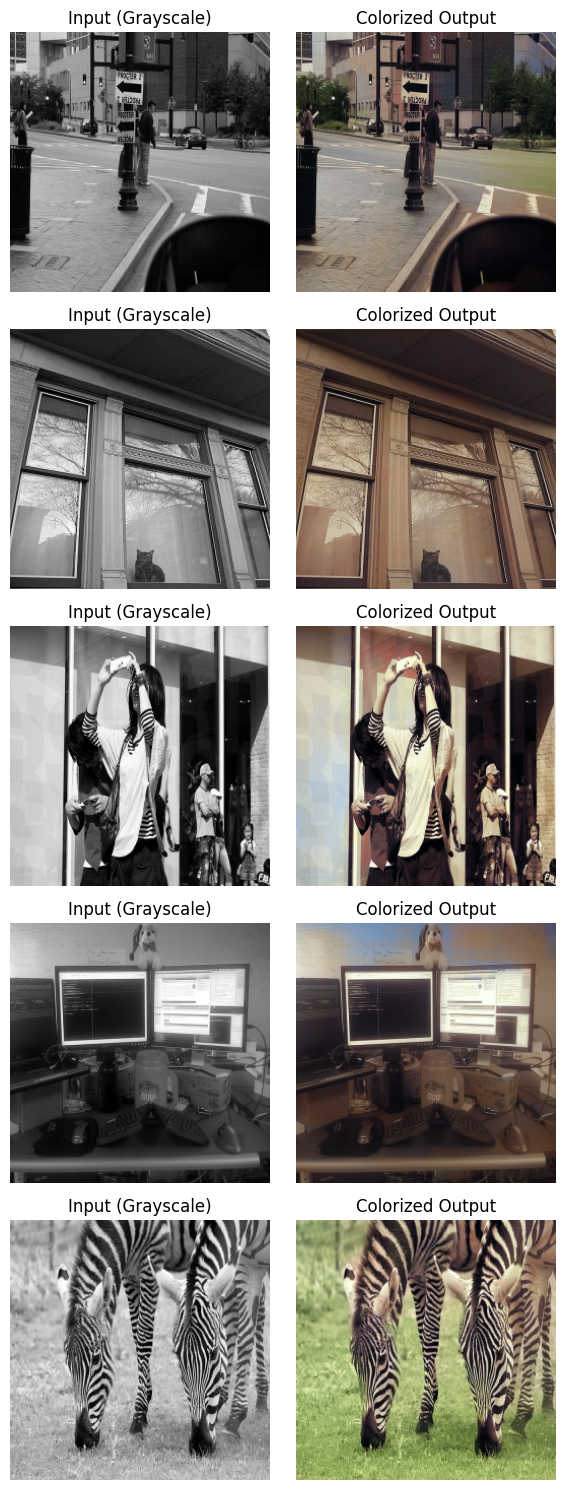


 Batch 2


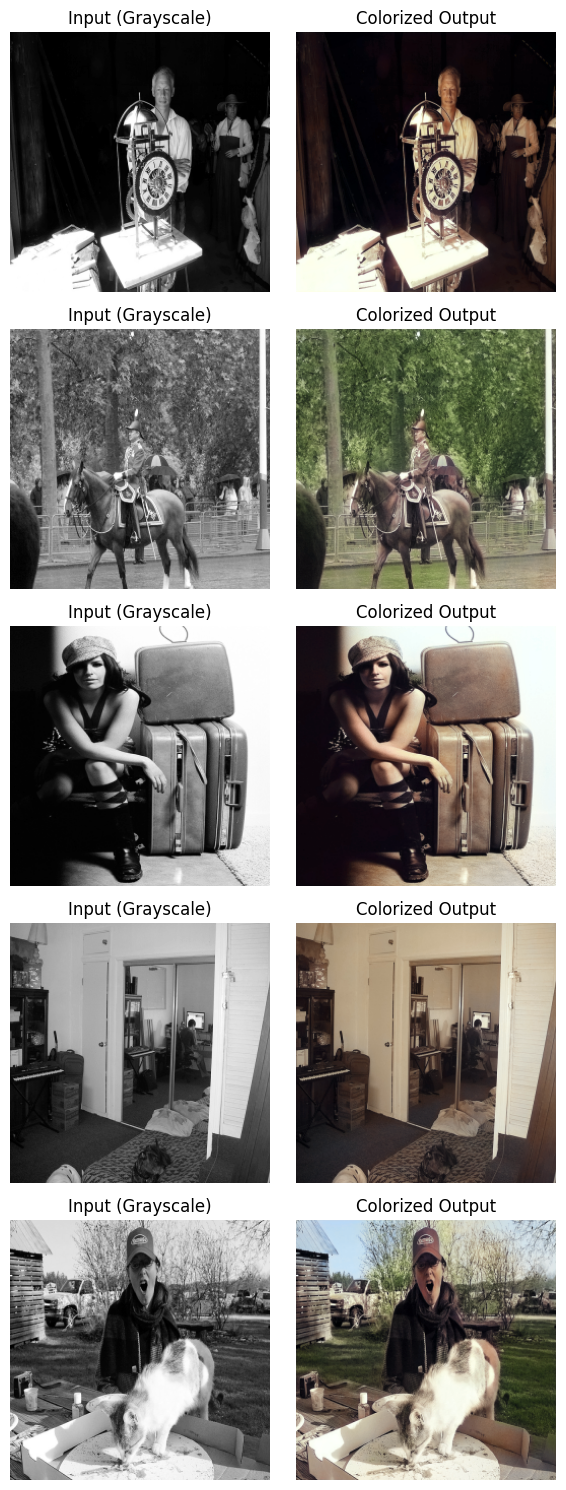


 Batch 3


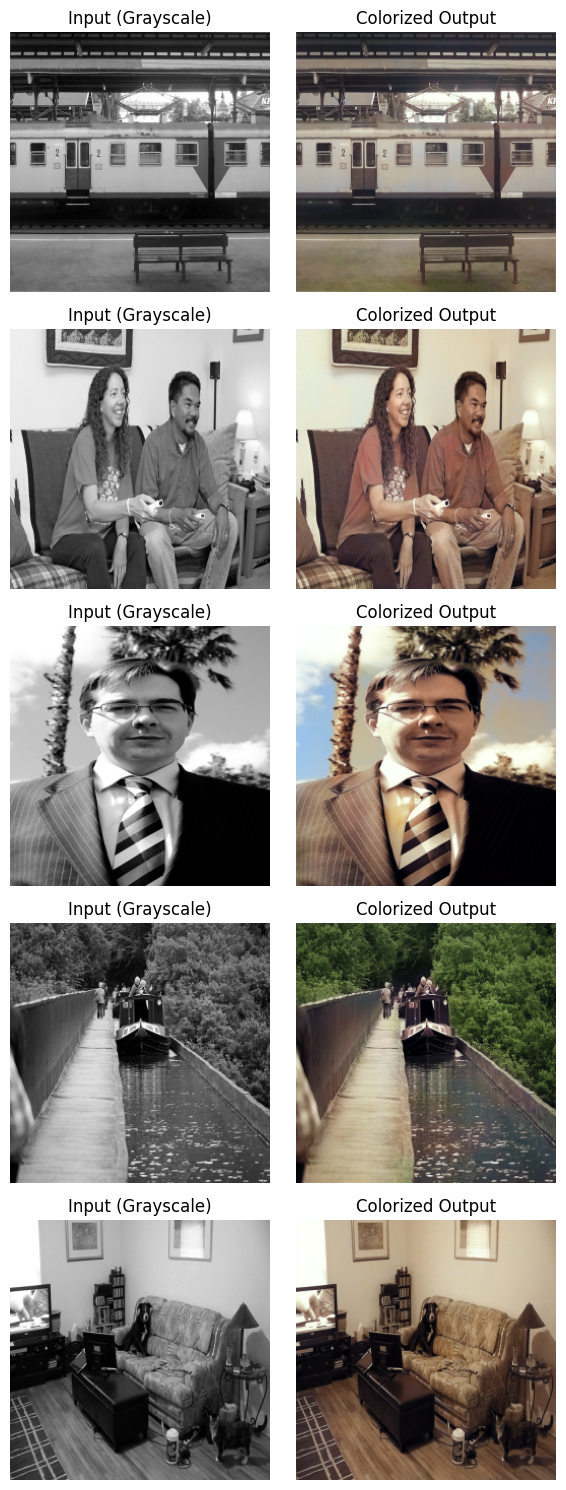


 Batch 4


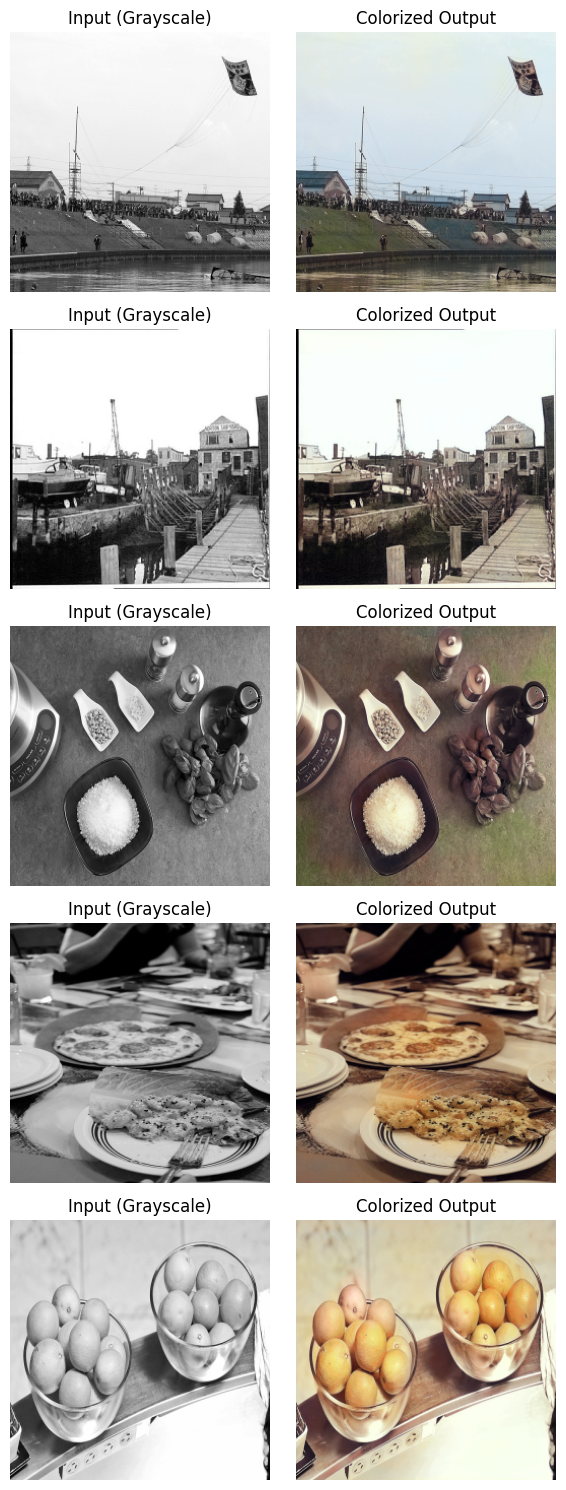


 Batch 5


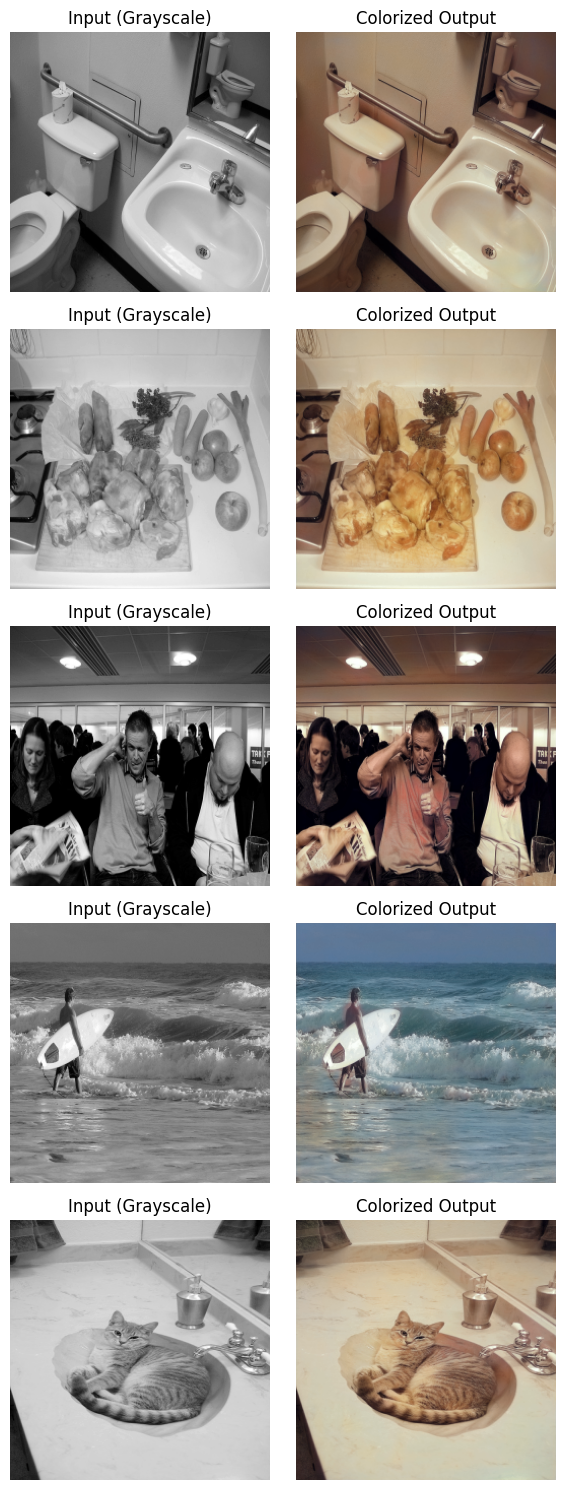

In [64]:
num_batches = 5
samples_per_batch = 5

val_iter = iter(val_loader)

for batch_num in range(num_batches):
    try:
        L_sample, _ = next(val_iter)
    except StopIteration:
        break
    
    L_sample = L_sample.to(device)

    with torch.no_grad():
        logits_s = model_samples(L_sample)
        probs = F.softmax(logits_s, dim=1)
        rgb_imgs = reconstruct(L_sample, probs) # [B, H, W, 3]

    print(f"Batch {batch_num+1}")
    show_results(L_sample, rgb_imgs, max_images = samples_per_batch)

## Inference

In [69]:
def infer_and_show(image_url, model, reconstruct_fn, device, img_size = (256, 256)):
    try:
        # 1) download image
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content)).convert('RGB')
    except Exception as e:
        print(f"Failed to load image")
        return

    # 2) resize and to numpy
    img_resized = img.resize(img_size)
    img_np = np.array(img_resized)
    
    # 3) LAB and normalize
    lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB).astype(np.float32)
    L = lab[:, :, 0]
    L_norm = (L / 50.0) - 1.0
    L_tensor = torch.from_numpy(L_norm).unsqueeze(0).unsqueeze(0).to(device)  # [1, 1, H, W]

    # 4) infer
    model.eval()
    with torch.no_grad():
        logits = model(L_tensor) # [1, 313, H, W]
        probs = F.softmax(logits, dim=1)
        rgb_image = reconstruct_fn(L_tensor, probs)  # numpy: [1, H, W, 3]

    # 5) idsplay
    L_gray = (L_tensor.repeat(1, 3, 1, 1).squeeze(0).permute(1, 2, 0) + 1.0) / 2.0 # [H, W, 3]
    rgb_image = rgb_image[0] # [H, W, 3]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(L_gray.cpu().numpy())
    plt.title("Input Grayscale")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(rgb_image)
    plt.title("Colorized Output")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

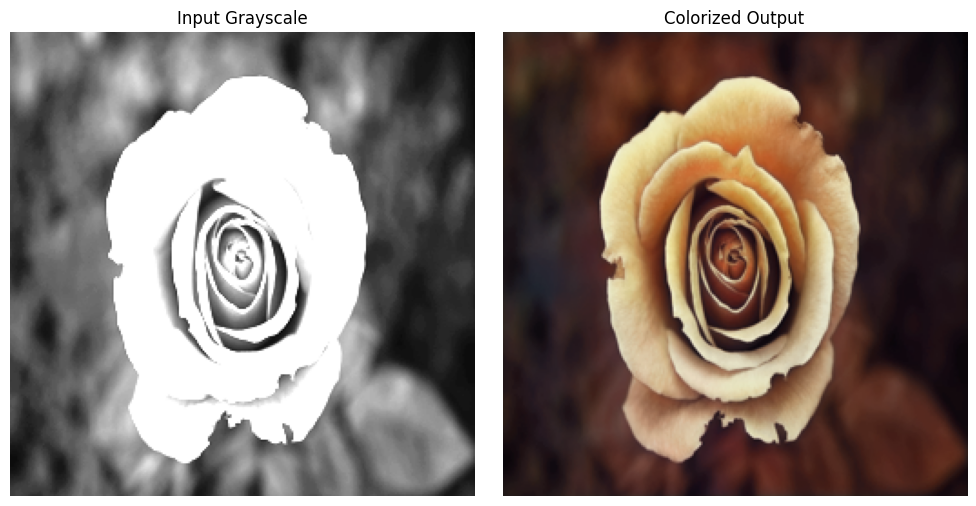

In [72]:
image_url = "https://images.pexels.com/photos/57905/pexels-photo-57905.jpeg?cs=srgb&dl=pexels-jhawley-57905.jpg&fm=jpg"
infer_and_show(image_url, model, reconstruct, device)

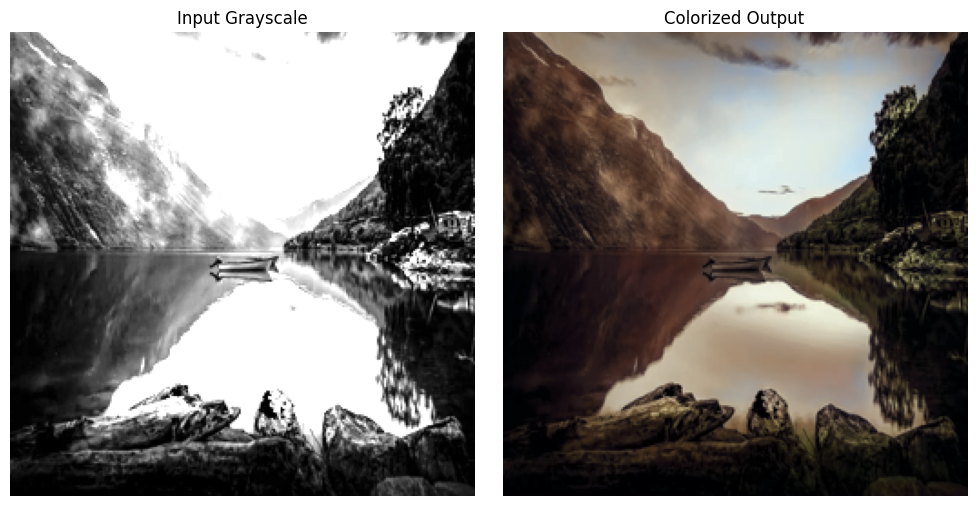

In [74]:
image_url = "https://www.cutoutimage.com/wp-content/uploads/2022/02/What-is-Black-and-white-photography.webp"
infer_and_show(image_url, model, reconstruct, device)

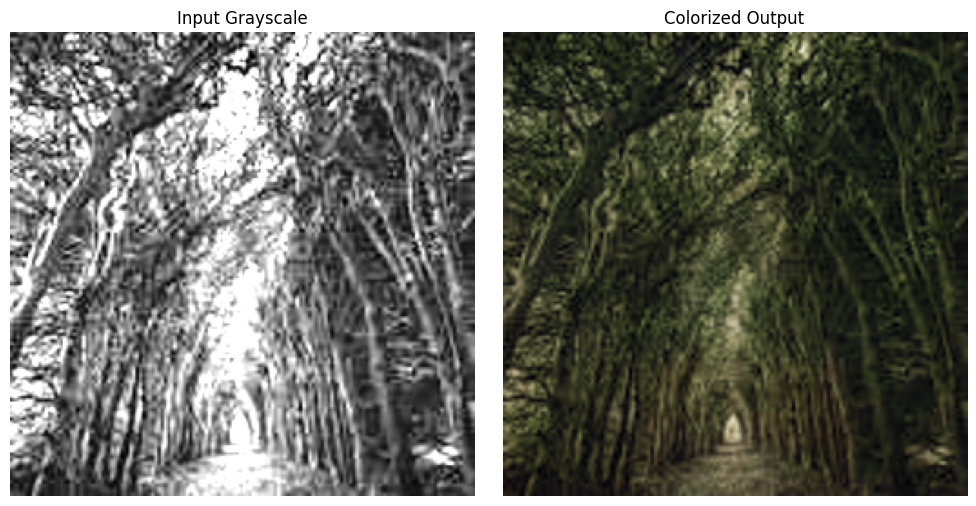

In [75]:
image_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQORO5a5eTV1AeSbn98mVCvvU7oy1g22XLA6QWug75PHHLGvWq3-kiYD64&s"
infer_and_show(image_url, model, reconstruct, device)

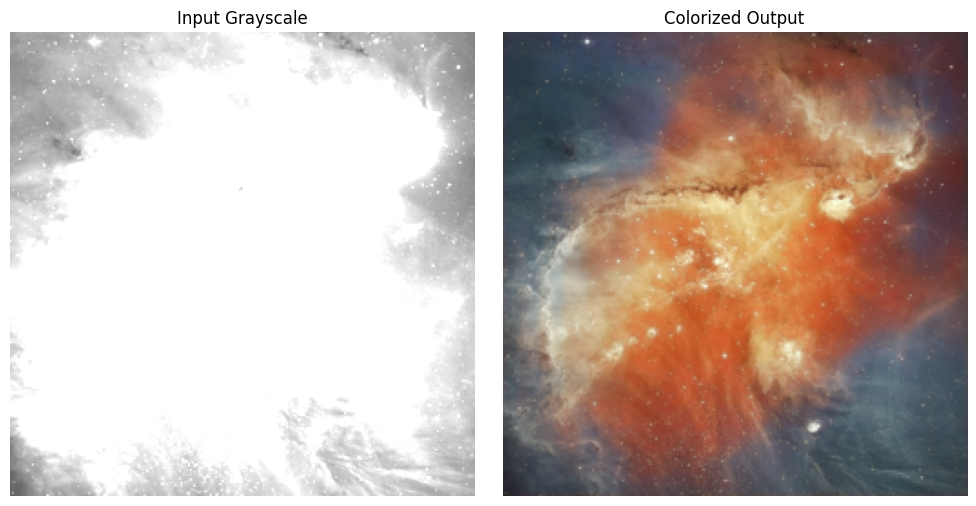

In [79]:
image_url = "https://cdn.esahubble.org/archives/images/large/heic0514b.jpg"
infer_and_show(image_url, model, reconstruct, device)

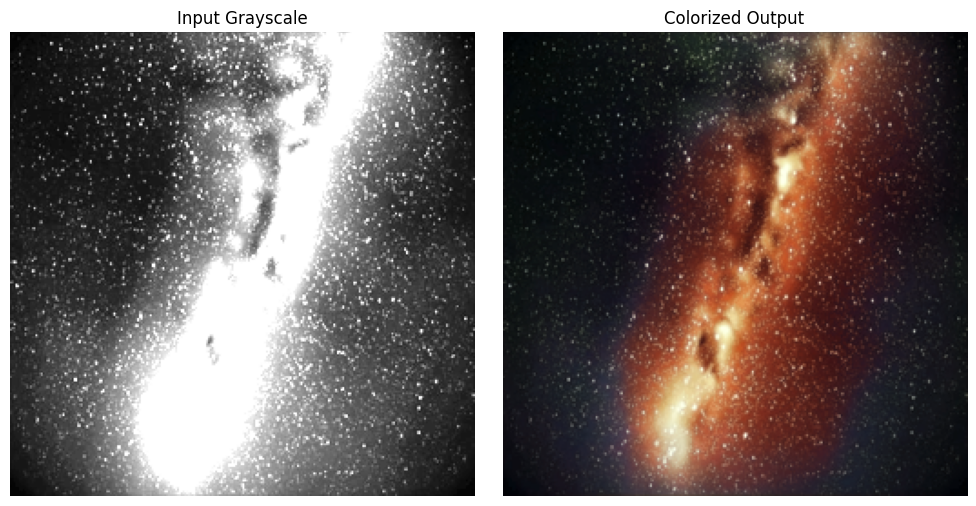

In [80]:
image_url = "https://media.istockphoto.com/id/1323821548/vector/night-starry-sky-and-milky-way.jpg?s=612x612&w=0&k=20&c=JG7SoN4KI8yLBTJl0n-mr7vTK-GH5KbmkTVqHHd0r3Q="
infer_and_show(image_url, model, reconstruct, device)